In [30]:
import random
import numpy as np
import matplotlib.pyplot as plt
import csv

#### Implementation of isolation forest

In [451]:
class InternalNode:
    def __init__(self, leftTree, rightTree, splitAttribute, splitValue):
        self.leftTree = leftTree
        self.rightTree = rightTree
        self.splitAttribute = splitAttribute
        self.splitValue = splitValue
        self.size = -1
        
class ExternalNode:
    def __init__(self, size):
        self.size = size

class IsolationTree:
    
    def __init__(self, data, currentHeight, heightLimit):
        self.root = self.createTree(data, currentHeight, heightLimit)
        self.heightLimit = heightLimit
        self.nData = np.size(data,0)
    
    def createTree(self, data, currentHeight, heightLimit):
        nData = np.size(data, 0)
        if(currentHeight >= heightLimit or nData <= 1):
            return ExternalNode(nData)
        else:
            nAttributes = np.size(data, 1)
            attributeIndex = random.randrange(0,nAttributes)
            minValue = np.min(data[:,attributeIndex])
            maxValue = np.max(data[:,attributeIndex])
            splitPoint = minValue + random.random()*(maxValue - minValue)
            xLeft = []
            xRight = []
            for i in range(0,nData):
                attributeValue = data[i,attributeIndex]
                if(attributeValue < splitPoint):
                    xLeft.append(data[i,:])
                else:
                    xRight.append(data[i,:])
            xLeft = np.array(xLeft)
            xRight = np.array(xRight)
            return InternalNode(IsolationTree(xLeft, currentHeight+1, heightLimit), IsolationTree(xRight, currentHeight + 1, heightLimit),attributeIndex, splitPoint)
    
    def displayTree(self, ax):
        minDist = 60*2
        initialDist = minDist*2**(self.heightLimit +1)
        self.displaySubtree(0,0,self.root, ax, initialDist)
    
    
    def displaySubtree(self, rootX, rootY, node,ax, distanceBetweenNodes):
        #Si el nodo es interno
        if(node.size == -1):
            layerHeight = 50
            
            leftNodeX = rootX - distanceBetweenNodes/2
            leftNodeY = rootY - layerHeight
            rightNodeX = rootX + distanceBetweenNodes/2
            rightNodeY = rootY - layerHeight
            ax.plot([rootX, leftNodeX],[rootY, leftNodeY],color = "#ba9114",linewidth = 2)
            ax.plot([rootX, rightNodeX],[rootY, rightNodeY], color = "#ba9114", linewidth = 2)
            ax.plot(rootX, rootY, marker = "o", color = "#f5c842", markersize = 60, linestyle = "none")
            ax.text(rootX, rootY, "A: " + str(node.splitAttribute) + " V: "+str(round(node.splitValue,1)), horizontalalignment = "center", fontsize = 10)
            self.displaySubtree(leftNodeX, leftNodeY, node.leftTree.root, ax,distanceBetweenNodes*0.5)
            self.displaySubtree(rightNodeX, rightNodeY, node.rightTree.root, ax,distanceBetweenNodes*0.5)
            
            
        #Si el nodo es externo
        else:
            ax.plot(rootX, rootY, marker = "o", color = "#428df5", markersize = 60, linestyle = "none")
            ax.set_ylim([rootY - 20, 20])
            
    
    
class IsolationForest:
    
    def __init__(self, data, nTrees, subSamplingRatio):
        nData = np.size(data,0)
        self.subSamplingSize = int(subSamplingRatio*nData)
        self.forest = []
        self.heightLimit = int(np.ceil(np.log2(self.subSamplingSize)))
        self.trainingData = data
        self.nTrees = nTrees
        for i in range(0,nTrees):
            subSampledData = self.sampleWithoutReplacement(data, self.subSamplingSize)
            iTree = IsolationTree(subSampledData, 1, self.heightLimit)
            self.forest.append(iTree)
        
        
    def sampleWithoutReplacement(self, data, sampleSize):
        
        nData = np.size(data,0)
        if(nData > sampleSize):
            nAttributes = np.size(data,1)
            sampledData = np.zeros((sampleSize, nAttributes))
            counter = 0
            alreadyChosen = []
            while(counter < sampleSize-1):
                newIndex = random.randrange(0,nData)
                if(not newIndex in alreadyChosen):
                    sampledData[counter,:] = data[newIndex,:]
                    alreadyChosen.append(newIndex)
                    counter = counter + 1 
            return sampledData
            
        return -1
    

    def getAnomalyRatings(self,data):
        n = np.size(data,0)
        cn = self.averageHeightFunction(n)
        anomalyRatings = []
        for i in range(0,n):
            vector = data[i,:]
            score = 0
            for j in range(0,self.nTrees):
                tree = self.forest[j]
                score += (1/self.nTrees)*self.pathLength(vector, tree, 0)
            anomalyRatings.append(2**(-score/cn))
        return anomalyRatings
                
    
    def averageHeightFunction(self, n):
        if(n == 0):
            return 0
        elif(n == 1):
            return 0
        else:
            h = np.log(n-1) + 0.5772156649
            return 2*h - (2*(n-1)/n)
    
    def pathLength(self, vector, tree, currentLength):
        if(tree.root.size != -1):
            return currentLength +self.averageHeightFunction(tree.root.size)
        else:
            a = tree.root.splitAttribute
            if(vector[a] < tree.root.splitValue):
                return self.pathLength(vector, tree.root.leftTree, currentLength + 1)
            else:
                return self.pathLength(vector, tree.root.rightTree, currentLength + 1)
    
    

#### Some classes for color codification according to anomaly rating

In [452]:
class ColorGenerator:
    #Regresa un esquema de colores aleatorio    
    def buildRandomScheme(self, numberOfColors):
        colorStrings = []
        for i in range(0,numberOfColors):
            colorStrings.append(self.getRandomColor())
            
        return colorStrings
        
    def getRandomColor(self):
        s = "#"
        r = str(hex(randrange(16)))[-1:] + str(hex(randrange(16)))[-1:]
        g = str(hex(randrange(16)))[-1:] + str(hex(randrange(16)))[-1:]
        b = str(hex(randrange(16)))[-1:] + str(hex(randrange(16)))[-1:]
        s = s+r+g+b
        
        return s
    
    def hex2Vector(self, value):
        r = int(value[1:3],16)
        g = int(value[3:5],16)
        b = int(value[5:7],16)
        
        return np.array([r,g,b])
    
    def getGradientColor(self, startColor, endColor, value, minValue, maxValue):
        color = startColor + ((value - minValue)/(maxValue - minValue))*(endColor - startColor)
        
        s = '#%02x%02x%02x' % (int(color[0]), int(color[1]), int(color[2]))
        return s
    
class ColorPointPlotter:
    
    def plotPointsWithColors(self, points, values, minColor, maxColor, title, ax):
        nPoints = np.size(points, 0)
        maxValue = np.max(values)
        minValue = np.min(values)
        colorGenerator = ColorGenerator()
        maxRegistered = False
        minRegistered = False
        
        for i in range(0,nPoints):
            point = points[i,:]
            pointColor = colorGenerator.getGradientColor(minColor, maxColor, values[i], minValue, maxValue)
            if(not maxRegistered and values[i] == maxValue):
                ax.plot(point[0], point[1], color = pointColor, marker = "o", linestyle = "none", label = "Max val. "+str(round(maxValue,2)))
                maxRegistered = True
            elif(not minRegistered and values[i] == minValue):
                ax.plot(point[0], point[1], color = pointColor, marker = "o", linestyle = "none", label = "Min val. "+str(round(minValue,2)))
                minRegistered = True
            else:
                ax.plot(point[0], point[1], color = pointColor, marker = "o", linestyle = "none")
        
        ax.set_title(title)
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        
        ax.legend()
        
    def plotPointsWithColorsMinMax(self, points, values, minColor, maxColor,minValue, maxValue, title, ax):
        nPoints = np.size(points, 0)
        colorGenerator = ColorGenerator()
        maxRegistered = False
        minRegistered = False
        firstPoint = points[0,:]
        ax.plot(firstPoint[0],firstPoint[1],color = maxColor/255, linestyle = "none", marker = "o", label = "Max val. "+str(round(maxValue, 2)))
        ax.plot(firstPoint[0],firstPoint[1], color = minColor/255, linestyle = "none", marker = "o", label = "Min val. "+str(round(minValue, 2)))
        for i in range(0,nPoints):
            point = points[i,:]
            pointColor = colorGenerator.getGradientColor(minColor, maxColor, values[i], minValue, maxValue)
            ax.plot(point[0], point[1], color = pointColor, marker = "o", linestyle = "none")
        ax.set_title(title)
        ax.set_xlabel("x")
        ax.set_ylabel("y")
        
        ax.legend()
        
            

In [453]:
def readFile(filePath):
    data = []
    with open(filePath, "r") as csvFile:
        csvReader = csv.reader(csvFile, delimiter = "\t")
        lineCounter = 0
        for row in csvReader:
            if(lineCounter == 0):
                lineCounter += 1
            else:
                vector = []
                for i in range(0,len(row)):
                    vector.append(float(row[i]))
                data.append(vector)
        
    return np.array(data)

In [454]:
data = readFile("zahn.dat")

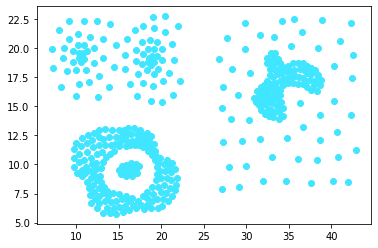

In [455]:
plt.figure()
plt.plot(data[:,0], data[:,1], color = "#40e6ff", marker = "o",linestyle = "none")

In [456]:
tree = IsolationTree(data,1, 4)

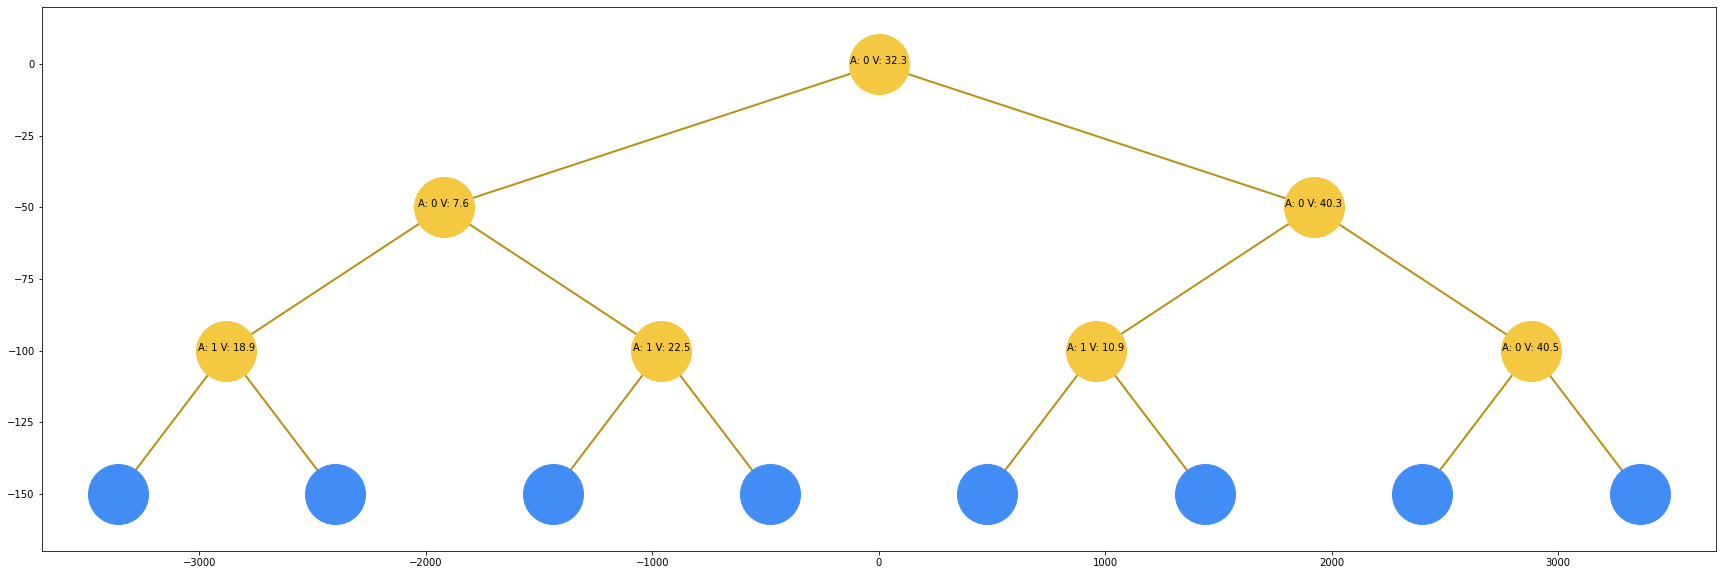

In [457]:
fig, ax = plt.subplots(figsize = (30,10))
tree.displayTree(ax)

In [467]:
dataWithAnomaly =list(data)
dataWithAnomaly.append(np.array([100,100]))
dataWithAnomaly = np.array(dataWithAnomaly)
nTrees = 100
subSamplingRatio = 0.5

forest = IsolationForest(dataWithAnomaly,nTrees, subSamplingRatio)


In [468]:
anomalyScores = forest.getAnomalyRatings(dataWithAnomaly)

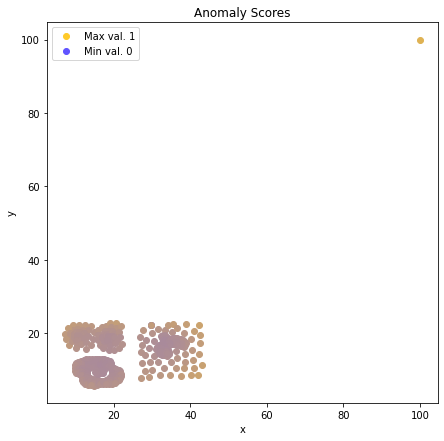

In [469]:
#Zahn compund with points colored according to their anomaly score
# i added an anomaly to the mix



colorPointPlotter = ColorPointPlotter()
cg = ColorGenerator()
colorMin = cg.hex2Vector("#6054ff")
colorMax = cg.hex2Vector("#ffca29")

fig, ax = plt.subplots(figsize = (7,7))

colorPointPlotter.plotPointsWithColorsMinMax(dataWithAnomaly, anomalyScores, colorMin, colorMax, 0, 1, "Anomaly Scores", ax)

In [470]:
max(anomalyScores)

0.8032396652494354